## Importing the all the required python packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

#Multihead Attention block

Multi-Head Attention allows a model to focus on different parts of the input sequence for different tasks. It operates on three key matrices: Query (Q), Key (K), and Value (V), producing an output that is a weighted sum of the values, where the weights are determined by the attention scores between the query and key.

## Multi-head attention with 3 linear layers
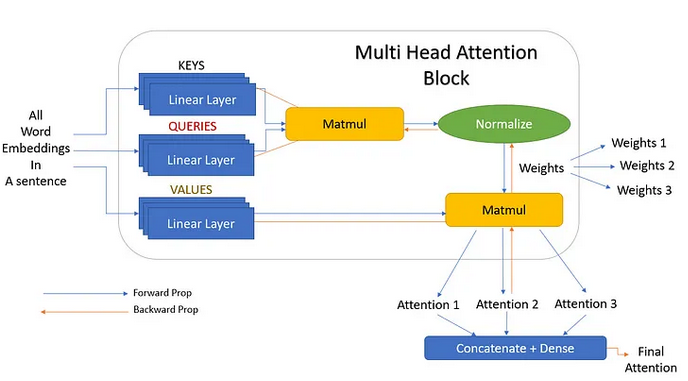

The MultiHeadAttention class includes functions for scaled dot-product attention, head splitting, head combination, and the forward pass.
This class provides a fundamental building block for building transformer-based models, enabling them to capture complex relationships in input data across multiple attention heads.

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

# Positionwise Feed Forward Network
The Position-Wise Feed-Forward Network (FFN) consists of two fully connected dense layers. The hidden layer, which is known as d_ff, is generally set to a value about four times that of d_model.
The ReLU activiation function, max(0, X), is used between the layers. It introduces non-linearity and helps prevent vanishing gradients.


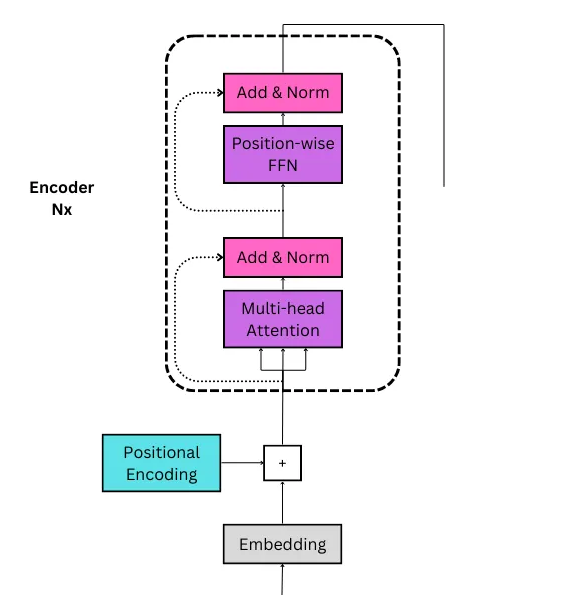

In [4]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# Positional Encoding
In any sentence, the words come one after the other to have a significant meaning.  But when a transformer loads the sentences, it does not do so in sequential order but loads them in parallel. This is where positional embeddings come in handy. This is sort of a vector encoding defining the position of a word which aded before giving the inputs vectors to the attention module. There are multiple ways of defining these positional embeddings. For example in the original paper — Attention is All You Need, the authors used an alternating sine and cosine function to define the embeddings, as shown in figure




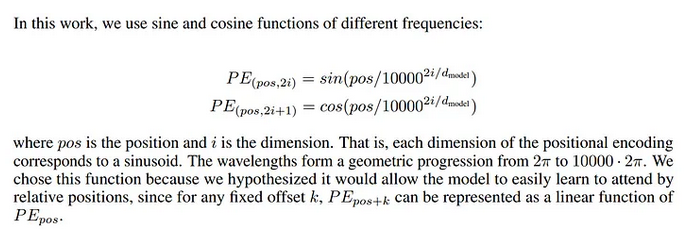.

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


# Transformer Encoder


The Transformer encoder is responsible for processing the input sequence (e.g., a sentence) and extracting meaningful representations from it. This is achieved through a series of layers, each consisting of two main components: Multi-Head Self-Attention and Position-Wise Feed-Forward Networks.



## Components of the Encoder
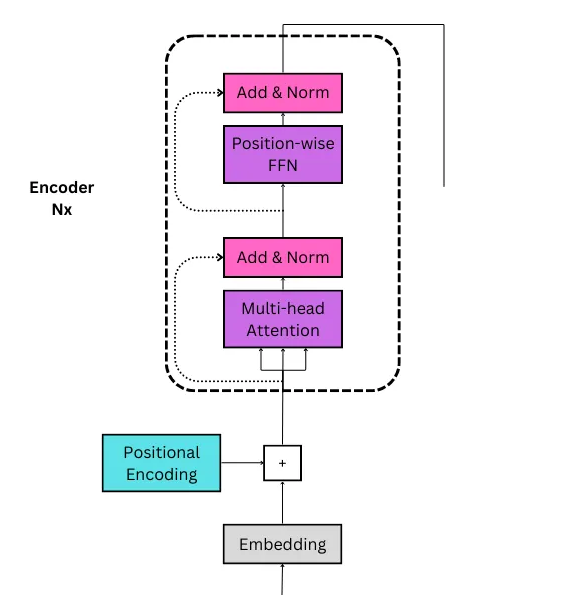


### Multi-Head Self-Attention

Self-attention mechanisms allow the model to weigh the importance of different words in the input sequence when encoding a specific word. The multi-head self-attention mechanism extends this concept by applying multiple sets of attention weights in parallel.

- **Input**: The input to the self-attention layer is a sequence of word embeddings, denoted as `X`, where each word has an associated vector representation.
- **Multi-Head Attention**: The layer computes multiple attention outputs, one for each attention head. This provides the model with the ability to focus on different aspects of the input sequence.
- **Concatenation and Linear Transformation**: The attention outputs from different heads are concatenated and linearly transformed to produce a single output vector.

### Position-Wise Feed-Forward Networks

The position-wise feed-forward network is applied to the output of the multi-head self-attention layer. It operates independently on each position in the sequence, allowing it to capture local patterns.

- **Input**: The input to the feed-forward network is the output of the self-attention layer.
- **Feed-Forward Transformation**: This layer consists of fully connected feed-forward networks with ReLU activation functions.
- **Output**: The output of the feed-forward network is another sequence of vectors with the same sequence length.

### Residual Connections and Layer Normalization

To facilitate the flow of information through the network and alleviate the vanishing gradient problem, residual connections are used. Additionally, layer normalization is applied to stabilize training.

### Layer Stacking

Multiple encoder layers are stacked on top of each other. Each layer refines the representations learned in the previous layer, enabling the model to capture increasingly abstract and complex features in the input data.



In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# Transformer Decoder
The Transformer decoder is responsible for generating the target sequence (e.g., translated sentence) based on the context learned by the encoder. It consists of several layers, each composed of three main components: Multi-Head Self-Attention, Multi-Head Encoder-Decoder Attention, and Position-Wise Feed-Forward Networks.

## Components of the Decoder


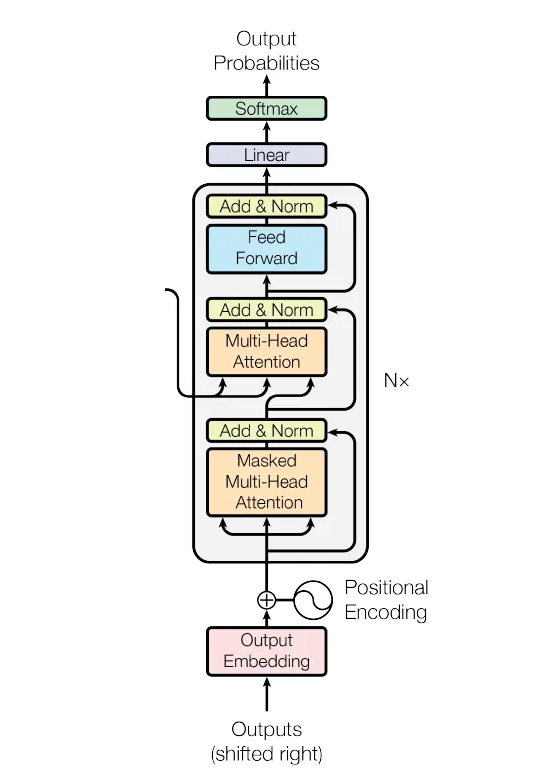

### Multi-Head Self-Attention

Similar to the encoder, the decoder employs multi-head self-attention mechanisms to focus on different parts of the target sequence during decoding.

- **Input**: The input to the self-attention layer is the previously generated part of the target sequence.
- **Multi-Head Attention**: It calculates attention weights to weigh the importance of different target positions.
- **Concatenation and Linear Transformation**: The outputs of multiple attention heads are concatenated and linearly transformed to produce the self-attention output.

### Multi-Head Encoder-Decoder Attention

This component allows the decoder to consider the context provided by the encoder's output when generating the target sequence.

- **Input**: The input to the encoder-decoder attention layer is the decoder's own multi-head self-attention output and the encoder's output from the top layer.
- **Multi-Head Attention**: Similar to self-attention, it computes attention scores between the decoder's output and the encoder's output.
- **Concatenation and Linear Transformation**: The attention outputs from different heads are concatenated and linearly transformed.

### Position-Wise Feed-Forward Networks

Position-wise feed-forward networks operate independently on each position in the decoder's output, capturing local patterns and relationships.

- **Input**: The input to the feed-forward network is the output of the encoder-decoder attention layer.
- **Feed-Forward Transformation**: This layer consists of fully connected feed-forward networks with ReLU activation functions.
- **Output**: The output of the feed-forward network is another sequence of vectors with the same sequence length.

### Residual Connections and Layer Normalization

To facilitate information flow and stabilize training, residual connections and layer normalization are applied within each layer.

### Masking

During training, a masking mechanism ensures that the decoder can only attend to positions earlier in the target sequence than the current position. This prevents the model from "cheating" by looking at future words during training.

### Layer Stacking

Multiple decoder layers are stacked on top of each other, with each layer refining the target sequence representations.


In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

# Transformers Network
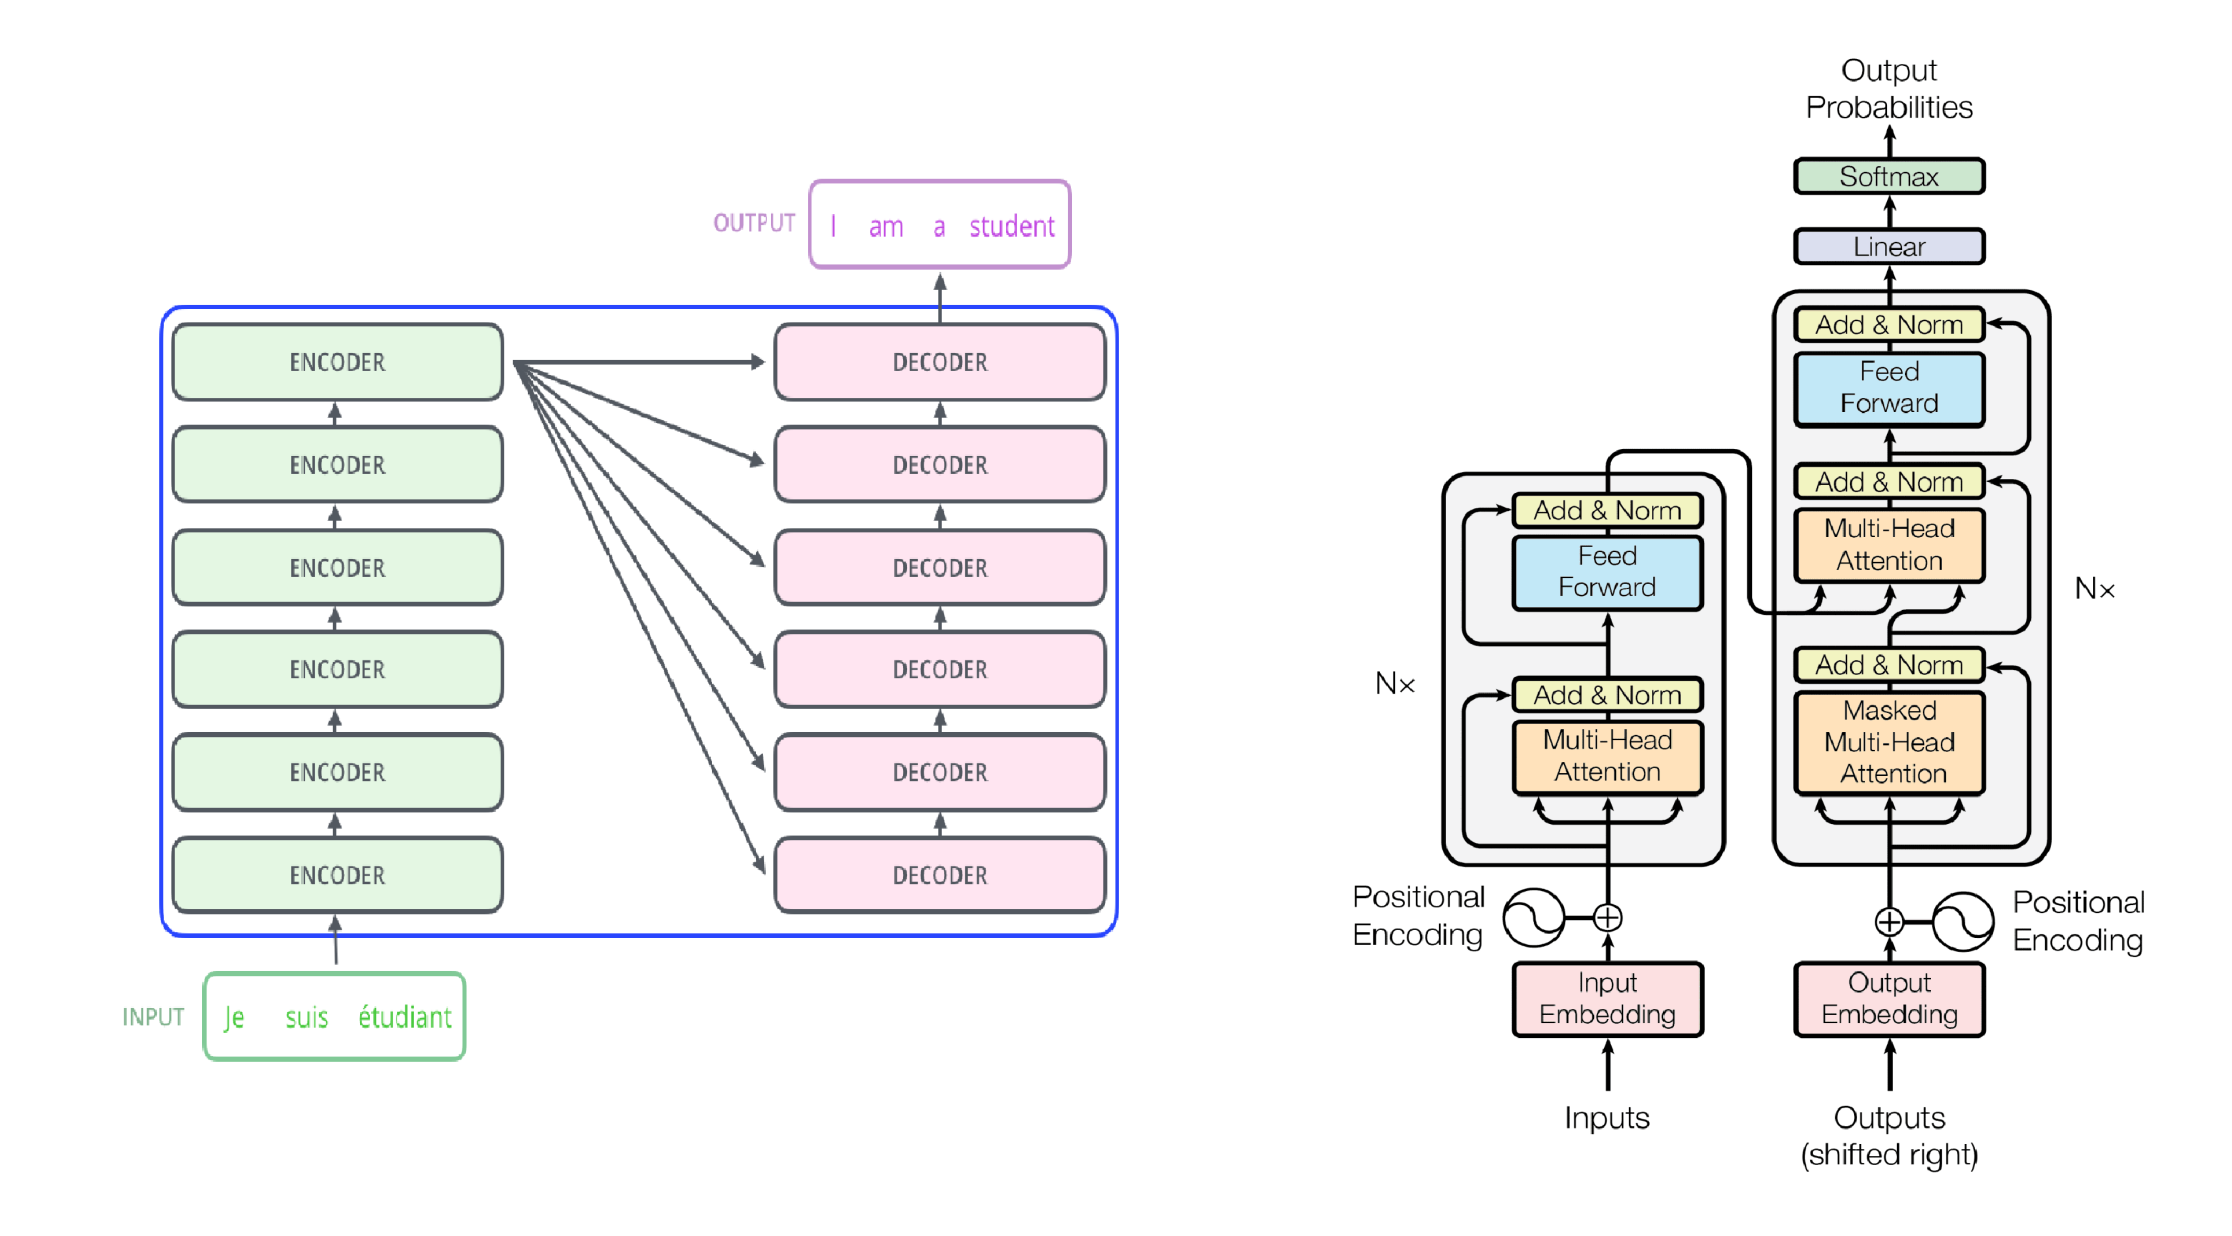

In [8]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

# Generating Random sample data

In [9]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

# Training Loop

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.673873901367188
Epoch: 2, Loss: 8.539525985717773
Epoch: 3, Loss: 8.478300094604492
Epoch: 4, Loss: 8.424525260925293
Epoch: 5, Loss: 8.370433807373047
Epoch: 6, Loss: 8.302239418029785
Epoch: 7, Loss: 8.22581672668457
Epoch: 8, Loss: 8.142484664916992
Epoch: 9, Loss: 8.06284236907959
Epoch: 10, Loss: 7.9820685386657715
Epoch: 11, Loss: 7.901917934417725
Epoch: 12, Loss: 7.8267502784729
Epoch: 13, Loss: 7.739485740661621
Epoch: 14, Loss: 7.653872013092041
Epoch: 15, Loss: 7.569296360015869
Epoch: 16, Loss: 7.4832000732421875
Epoch: 17, Loss: 7.409486293792725
Epoch: 18, Loss: 7.324971675872803
Epoch: 19, Loss: 7.246689796447754
Epoch: 20, Loss: 7.156452178955078
Epoch: 21, Loss: 7.082314968109131
Epoch: 22, Loss: 7.000692844390869
Epoch: 23, Loss: 6.926970958709717
Epoch: 24, Loss: 6.852006912231445
Epoch: 25, Loss: 6.77702522277832
Epoch: 26, Loss: 6.6992692947387695
Epoch: 27, Loss: 6.62480354309082
Epoch: 28, Loss: 6.547569751739502
Epoch: 29, Loss: 6.4744606018066